In [1]:
#Importing Libraries
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale our data
from sklearn.preprocessing import scale

# To perform KMeans clustering 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
#reading Dataset
retail = pd.read_excel("mechanics.xlsx")
#if you dont use encoding option , you will get the following error ""UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa3 in position 28: invalid start byte""
# parse date
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format = "%d-%m-%Y %H:%M")

In [3]:
retail.head()

,InvoiceNo,Quantity,InvoiceDate,Unit price,Customer Id,city,state
0,536365,16,2020-09-06,355,17850,Ganganagar,Rajasthan
1,536365,21,2020-09-16,573,17850,Ganganagar,Rajasthan
2,536365,6,2020-12-10,251,17850,Coimbatore,Tamil Nadu
3,536365,25,2020-10-02,453,17850,Madurai,Tamil Nadu
4,536365,13,2020-09-29,340,17850,Porbandar,Gujarat


In [4]:
#Sanity Check
retail.shape
retail.describe()
retail.info()
retail.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9998 entries, 0 to 9997
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    9998 non-null   object        
 1   Quantity     9998 non-null   int64         
 2   InvoiceDate  9998 non-null   datetime64[ns]
 3   Unit price   9998 non-null   int64         
 4   Customer Id  9998 non-null   int64         
 5   city         9998 non-null   object        
 6   state        9998 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 546.9+ KB


(9998, 7)

In [5]:
#Na Handling
retail.isnull().values.any()
retail.isnull().values.sum()
retail.isnull().sum()*100/retail.shape[0]

InvoiceNo      0.0
Quantity       0.0
InvoiceDate    0.0
Unit price     0.0
Customer Id    0.0
city           0.0
state          0.0
dtype: float64

In [6]:

# Extracting amount by multiplying quantity and unit price and saving the data into amount variable.
amount  = pd.DataFrame(retail["Quantity"] * retail["Unit price"], columns = ["Amount"])
amount.head()

,Amount
0,5680
1,12033
2,1506
3,11325
4,4420


In [7]:
#merging amount in order_wise
retail = pd.concat(objs = [retail, amount], axis = 1, ignore_index = False)

#Monetary Function
# Finding total amount spent per customer
monetary = retail.groupby("Customer Id")[["Amount"]].sum()
monetary = monetary.reset_index()
monetary.head()

,Customer Id,Amount
0,12431,115534
1,12583,227655
2,12791,15886
3,13047,187421
4,13408,97352


In [8]:
#Frequency function
frequency = retail[['Customer Id', 'InvoiceNo']]

In [9]:
# Getting the count of orders made by each customer based on customer ID.
k = frequency.groupby("Customer Id").InvoiceNo.count()
k = pd.DataFrame(k)
k = k.reset_index()
k.columns = ["Customer Id", "Frequency"]
k.head()

,Customer Id,Frequency
0,12431,14
1,12583,20
2,12791,2
3,13047,17
4,13408,11


In [10]:
#creating master dataset
master = monetary.merge(k, on = "Customer Id", how = "inner")
master.head()

,Customer Id,Amount,Frequency
0,12431,115534,14
1,12583,227655,20
2,12791,15886,2
3,13047,187421,17
4,13408,97352,11


In [11]:
recency  = retail[['Customer Id','InvoiceDate']]
maximum = max(recency.InvoiceDate)

In [12]:
maximum

Timestamp('2020-12-31 00:00:00')

In [13]:
#Generating recency function

# Filtering data for customerid and invoice_date
recency  = retail[['Customer Id','InvoiceDate']]

# Finding max data
maximum = max(recency.InvoiceDate)

# Adding one more day to the max data, so that the max date will have 1 as the difference and not zero.
maximum = maximum + pd.DateOffset(days=1)
recency['diff'] = maximum - recency.InvoiceDate
recency.head()

<ipython-input-13-c285ffbc015f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recency['diff'] = maximum - recency.InvoiceDate


,Customer Id,InvoiceDate,diff
0,17850,2020-09-06,117 days
1,17850,2020-09-16,107 days
2,17850,2020-12-10,22 days
3,17850,2020-10-02,91 days
4,17850,2020-09-29,94 days


In [14]:
# recency by customerid
a = recency.groupby('Customer Id')

In [15]:
b=min(a["diff"])
b

(12431,
 197    98 days
 198    38 days
 199    67 days
 200    19 days
 201    17 days
 202    42 days
 203    80 days
 204     9 days
 205   125 days
 206    22 days
 207   140 days
 208    33 days
 209   140 days
 210    68 days
 Name: diff, dtype: timedelta64[ns])

In [16]:
#Dataframe merging by recency
df = pd.DataFrame(recency.groupby('Customer Id')[["diff"]].min())
df = df.reset_index()
df.columns = ["Customer Id", "Recency"]
df.head()

,Customer Id,Recency
0,12431,9 days
1,12583,10 days
2,12791,116 days
3,13047,24 days
4,13408,24 days


In [17]:
#Combining all recency, frequency and monetary parameters
RFM = k.merge(monetary, on = "Customer Id")
RFM = RFM.merge(df, on = "Customer Id")
RFM.head()

,Customer Id,Frequency,Amount,Recency
0,12431,14,115534,9 days
1,12583,20,227655,10 days
2,12791,2,15886,116 days
3,13047,17,187421,24 days
4,13408,11,97352,24 days


In [18]:
    # standardise all parameters
RFM_norm1 = RFM.drop(["Customer Id"], axis=1)
RFM_norm1.Recency = RFM_norm1.Recency.dt.days

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)

In [19]:
RFM_norm1 = pd.DataFrame(RFM_norm1)
RFM_norm1.columns = ['Frequency','Amount','Recency']
RFM_norm1.head()

,Frequency,Amount,Recency
0,7.570749,6.159057,-1.522671
1,11.081879,12.714944,-1.500064
2,0.548490,0.332486,0.896301
3,9.326314,10.362401,-1.183563
4,5.815184,5.095928,-1.183563


In [20]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [21]:
hopkins(RFM_norm1)

0.9988414570501661

In [22]:
# Kmeans with K=5
model_clus5 = KMeans(n_clusters = 5, max_iter=50)
model_clus5.fit(RFM_norm1)

KMeans(max_iter=50, n_clusters=5)

In [23]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(RFM_norm1)
    sse_.append([k, silhouette_score(RFM_norm1, kmeans.labels_)])

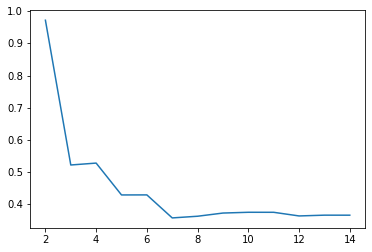

In [24]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

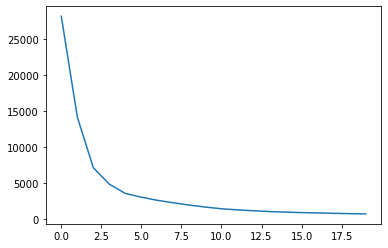

In [25]:
# sum of squared distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(RFM_norm1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [26]:
pd.RangeIndex(len(RFM.index))

RangeIndex(start=0, stop=9408, step=1)

In [27]:
RFM_km = pd.concat([RFM, pd.Series(model_clus5.labels_)], axis=1)
RFM_km.columns = ['CustomerId', 'Frequency', 'Amount', 'Recency', 'ClusterID']

RFM_km.Recency = RFM_km.Recency.dt.days
km_clusters_amount =    pd.DataFrame(RFM_km.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency =     pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency =   pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())

In [28]:
RFM_km

,CustomerId,Frequency,Amount,Recency,ClusterID
0,12431,14,115534,9,4
1,12583,20,227655,10,4
2,12791,2,15886,116,0
3,13047,17,187421,24,4
4,13408,11,97352,24,4
...,...,...,...,...,...
9403,69994,1,6903,58,1
9404,69995,1,6318,109,0
9405,69996,1,14496,61,1
9406,69997,1,25069,22,3


In [29]:
RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([RFM, pd.Series(model_clus5.labels_)], axis=1)
RFM_km.columns = ['Customer Id', 'Frequency', 'Amount', 'Recency', 'ClusterID']

RFM_km.Recency = RFM_km.Recency.dt.days
km_clusters_amount = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())

In [30]:
km_clusters_amount

,Amount
ClusterID,
0,9773.165482
1,9538.062802
2,609769.600000
3,9553.863280
4,172593.266667


In [31]:
RFM_km.head()
RFM_km

,Customer Id,Frequency,Amount,Recency,ClusterID
0,12431,14,115534,9,4
1,12583,20,227655,10,4
2,12791,2,15886,116,0
3,13047,17,187421,24,4
4,13408,11,97352,24,4
...,...,...,...,...,...
9403,69994,1,6903,58,1
9404,69995,1,6318,109,0
9405,69996,1,14496,61,1
9406,69997,1,25069,22,3


In [32]:
Recent=RFM_km.drop(["Customer Id","Frequency","Amount"],axis=1)

<AxesSubplot:>

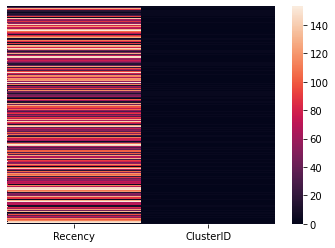

In [33]:
sns.heatmap(data=Recent,yticklabels=False)

<AxesSubplot:xlabel='ClusterID', ylabel='Count'>

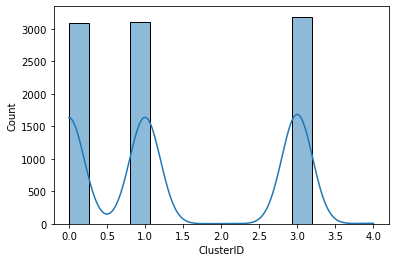

In [34]:
sns.histplot(data=Recent,x="ClusterID",kde=True)

<AxesSubplot:>

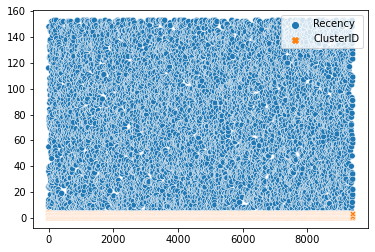

In [35]:
sns.scatterplot(data=Recent)

In [36]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ClusterID       5 non-null      int64  
 1   Amount_mean     5 non-null      float64
 2   Frequency_mean  5 non-null      float64
 3   Recency_mean    5 non-null      float64
dtypes: float64(3), int64(1)
memory usage: 288.0 bytes


<AxesSubplot:xlabel='ClusterID', ylabel='Amount_mean'>

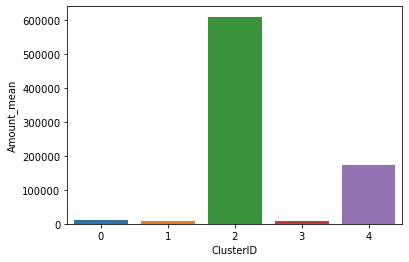

In [37]:
sns.barplot(x=df.ClusterID, y=df.Amount_mean)

<AxesSubplot:xlabel='ClusterID', ylabel='Frequency_mean'>

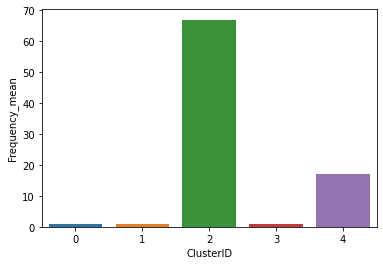

In [38]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

<AxesSubplot:xlabel='ClusterID', ylabel='Recency_mean'>

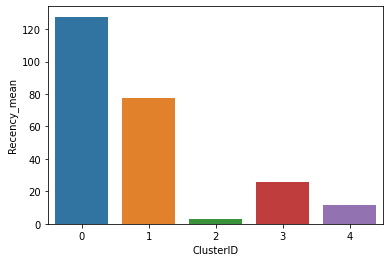

In [39]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)

In [40]:
#df1 = df[df.ClusterID==0]
#df2 = df[df.ClusterID==1]

#plt.scatter(df1.ClusterID,df1['Recency_mean'],color='green')
#plt.scatter(df2.ClusterID,df2['Recency_mean'],color='red')

#plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',label='centroid')
#plt.legend()

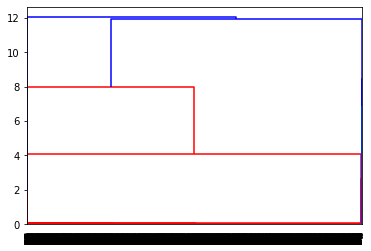

In [41]:
# heirarchical clustering
mergings = linkage(RFM_norm1, method = "single", metric='euclidean')
dendrogram(mergings)
plt.show()

In [ ]:
mergings = linkage(RFM_norm1, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [ ]:
clusterCut = pd.Series(cut_tree(mergings, n_clusters = 5).reshape(-1,))
RFM_hc = pd.concat([RFM, clusterCut], axis=1)
RFM_hc.columns = ['Customer Id', 'Frequency', 'Amount', 'Recency', 'ClusterID']

In [ ]:
#summarise
RFM_hc.Recency = RFM_hc.Recency.dt.days
km_clusters_amount = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Recency.mean())

In [ ]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df

In [ ]:
sns.barplot(x=df.ClusterID, y=df.Amount_mean)

In [ ]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

In [ ]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)